# Simulación y análisis bayesiano del modelo IRT 1PL

Este notebook simula dificultades de ítems y habilidades de personas, genera respuestas bajo el modelo 1PL, y compara estimaciones clásicas y bayesianas. Se sigue una estructura similar al análisis de faltas NBA, pero con datos simulados para ilustrar el proceso completo.

In [ ]:
# Importar librerías y configurar entorno
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import r2_score


RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 1. Simulación de parámetros

Generamos 80 dificultades de ítems y 1000 habilidades de personas, ambos de una normal estándar.

In [3]:
# Parámetros de simulación
n_items = 80
n_persons = 1000

# Dificultades de los ítems (b)
item_difficulties = rng.normal(0, 1, n_items)

# Habilidades de las personas (theta)
person_abilities = rng.normal(0, 1, n_persons)

## 2. Generación de predicciones de dificultad con R² de discriminación 0.5

Simulamos predicciones correlacionadas con las dificultades verdaderas, usando una correlación de 0.5.

In [3]:
# Generar predicciones correlacionadas (R² ~ 0.5)
r = 0.5
sd_true = 1
sd_pred = 1
cov = r * sd_true * sd_pred
mean = [0, 0]
cov_matrix = [[sd_true**2, cov], [cov, sd_pred**2]]
sim = rng.multivariate_normal(mean, cov_matrix, n_items)
true_b = sim[:, 0]
pred_b = sim[:, 1]
print("R²:", r2_score(true_b, pred_b))

R²: -0.27337054164671537


## 3. Simulación de respuestas

Generamos una matriz de respuestas binarias usando el modelo 1PL:  
P(respuesta correcta) = sigmoid(theta - b)

In [4]:
# Simulación de respuestas
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

responses = np.zeros((n_persons, n_items))
for i, theta in enumerate(person_abilities):
    p = sigmoid(theta - item_difficulties)
    responses[i, :] = rng.binomial(1, p)
responses_df = pd.DataFrame(responses, columns=[f"Item_{j+1}" for j in range(n_items)])

responses_df.head()

,Item_1,Item_2,Item_3,Item_4,Item_5,Item_6,Item_7,Item_8,Item_9,Item_10,...,Item_71,Item_72,Item_73,Item_74,Item_75,Item_76,Item_77,Item_78,Item_79,Item_80
0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## 4. Estimación clásica del modelo 1PL

Estimamos las dificultades de los ítems usando máxima verosimilitud.

In [11]:
from girth import rasch_mml

# Adaptación: usar el DataFrame responses_df creado previamente
# responses_df: filas = personas, columnas = ítems (0/1)
X = responses_df.to_numpy().astype(int).T
print(f"Shape matriz de respuestas (personas, items): {X.shape}")

# Estimación Rasch (MMLE)
result = rasch_mml(X)
delta_hat = result['Difficulty']  # dificultades estimadas (pueden venir centradas a media ~0)

print("Primeras 5 dificultades estimadas:", delta_hat[:5])

Shape matriz de respuestas (personas, items): (80, 1000)
Primeras 5 dificultades estimadas: [-0.21345446  1.27763033 -0.59609861  0.68356688  1.08115271]


In [12]:
print(delta_hat.shape)

(80,)


In [13]:
print(item_difficulties.shape)

(80,)


In [14]:
from sklearn.metrics import r2_score

print("Correlación MLE vs. Verdadero:", np.corrcoef(delta_hat, item_difficulties)[0,1])

Correlación MLE vs. Verdadero: 0.9959598403392336


Correlación MLE vs. Verdadero: 0.9966234308309515
Coeficiente de determinación (R²) de pred_b vs. true_b: -0.2734


In [15]:
print(f"Coeficiente de determinación (R²) de MLE: {r2_score(mle_b, item_difficulties):.4f}")

Coeficiente de determinación (R²) de MLE: 0.9929


## 5. Modelo bayesiano 1PL con coordenadas

Definimos el modelo bayesiano 1PL usando coordenadas para ítems y personas, y visualizamos su estructura.

In [6]:
# Definir coordenadas para el modelo bayesiano
coords = {
    "person": np.arange(n_persons),
    "item": np.arange(n_items)
}
# Estimación Bayesiana con PyMC3
with pm.Model(coords=coords) as irt_1pl_coords:
    theta = pm.Normal("theta", mu=0, sigma=1, dims="person")
    b = pm.Normal("b", mu=0, sigma=1, dims="item")
    p = pm.Deterministic("p", pm.math.sigmoid(theta[:, None] - b[None, :]))
    responses_obs = pm.Bernoulli("responses", p=p, observed=responses)


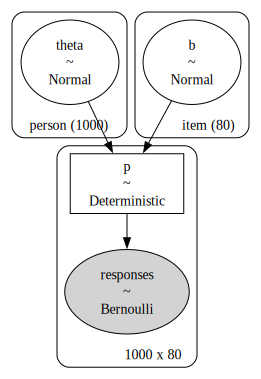

In [7]:
# Visualización del grafo del modelo y muestreo posterior
pm.model_to_graphviz(irt_1pl_coords)

In [8]:
with irt_1pl_coords:
    trace_coords = pm.sample(1000, tune=1000, target_accept=0.95, chains=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, b]
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 203 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


## 6. Comparación de estimaciones

Comparamos las estimaciones clásicas y bayesianas con los valores verdaderos.

Correlación Bayes vs. Verdadero: 0.9966158645927539


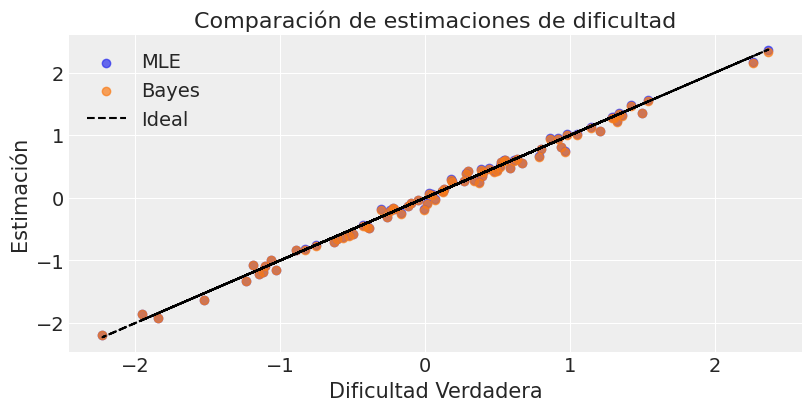

In [10]:
# Extraer estimaciones bayesianas
t_bayes = trace_coords.posterior['b'].mean(dim=("chain", "draw")).values
print("Correlación Bayes vs. Verdadero:", np.corrcoef(t_bayes, item_difficulties)[0,1])

# Comparación visual
plt.figure(figsize=(8,4))
plt.scatter(item_difficulties, mle_b, label="MLE", alpha=0.7)
plt.scatter(item_difficulties, t_bayes, label="Bayes", alpha=0.7)
plt.plot(item_difficulties, item_difficulties, 'k--', label="Ideal")
plt.xlabel("Dificultad Verdadera")
plt.ylabel("Estimación")
plt.legend()
plt.title("Comparación de estimaciones de dificultad")
plt.show()

In [ ]:
print(f"Coeficiente de determinación (R²) de MLE: {r2_score(mle_b, item_difficulties):.4f}")
print(f"Coeficiente de determinación (R²) de Bayes: {r2_score(t_bayes, item_difficulties):.4f}")

Coeficiente de determinación (R²) de MLE: 0.9929
Coeficiente de determinación (R²) de Bayes: 0.9923


In [20]:
mae_mle = np.mean(np.abs(mle_b - item_difficulties))
mae_bayes = np.mean(np.abs(t_bayes - item_difficulties))
print(f"MAE MLE: {mae_mle:.4f}")
print(f"MAE Bayes: {mae_bayes:.4f}")

MAE MLE: 0.0618
MAE Bayes: 0.0640


## 7. Conclusiones

Se han comparado los métodos clásico y bayesiano para estimar dificultades en el modelo 1PL, mostrando la recuperación de parámetros bajo simulación controlada.